In [149]:
!pip install tsai
import pandas as pd
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy.random as npr
import os
import time

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


# Data preparation

In [16]:
df = pd.read_csv("5sec_intervals_no_na_normed.csv")
df = df[['PRICE', 'SIZE', 'vol']]
df.head()

,PRICE,SIZE,vol
0,-1.713467,0.000773,2.098651
1,-1.719555,0.036915,2.068303
2,-1.718412,0.048620,2.006872
3,-1.720527,0.095456,1.834030
4,-1.719023,0.023657,1.833023


In [36]:
train_data = df[:round(0.8 * len(df))].copy()
test_data = df[train_data.iloc[-1].name+1:]

In [65]:
train_data[:120]

,PRICE,SIZE,vol
0,-1.713467,0.000773,2.098651
1,-1.719555,0.036915,2.068303
2,-1.718412,0.048620,2.006872
3,-1.720527,0.095456,1.834030
4,-1.719023,0.023657,1.833023
...,...,...,...
115,-1.714687,-0.006404,1.818437
116,-1.718210,0.009351,1.817190
117,-1.716480,0.062125,1.818805
118,-1.717838,-0.020977,1.809160


In [50]:
train_data_normalized = torch.FloatTensor(train_data.to_numpy().tolist())
test_data_normalized = torch.FloatTensor(test_data.to_numpy().tolist())

In [58]:
test_data_normalized[:, 2]

tensor([-0.6298, -0.6214, -0.6266,  ...,  0.5650,  0.5892,  0.6046])

In [119]:
def create_inout_sequences(input_data, tw, sl):
    """
    tw: train_window
    sl: sequence_length
    """
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw-sl):
        train_seq = input_data[i:i+tw]
        # Select the volatility column
        train_label = input_data[i+tw:i+tw+sl, 2]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 100
pred_seq_len = 20

# Prepare sequences
train_sequence = create_inout_sequences(train_data.to_numpy(), train_window, pred_seq_len)
test_sequence = create_inout_sequences(test_data.to_numpy(), train_window, pred_seq_len)

# Training Utilities

In [121]:
def get_batch(x, y, batch_size):
    """
    Generator that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = np.array(x[i : i + batch_size])
        batch_y = np.array(y[i : i + batch_size])
        yield (batch_x, batch_y)

In [124]:
train_x = [t[0] for t in train_sequence]
train_y = [t[1] for t in train_sequence]

batches = get_batch(train_x, train_y, 64)

In [153]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)


def run_validation_step(
    model,
    criterion,
    inputs,
    labels,
    batch_size,
    gpu,
    plotpath=None,
    visualize=True,
    downsize_input=False
):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(inputs, labels, batch_size)):
        inputs, labels = get_torch_vars(xs, ys, gpu)
        outputs = model(inputs)

        val_loss = criterion(outputs, labels)
        losses.append(val_loss.data.item())

        # _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0)
        # It is correct if predicted within a certain std
        std = np.std(labels.data)
        correct += (outputs == labels.data).sum()

#     if plotpath:  # only plot if a path is provided
#         plot(
#             xs,
#             ys,
#             predicted.cpu().numpy(),
#             colours,
#             plotpath,
#             visualize=visualize,
#             compare_bilinear=downsize_input,
#         )

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [155]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
        
def train(args, model=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if model is None:
        # Net = globals()[args.model]
        model = VolForecast(input_size=args.input_size, output_size=args.output_size)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    train_sequence = create_inout_sequences(train_data.to_numpy(), args.sequence_len, args.output_size)
    test_sequence = create_inout_sequences(test_data.to_numpy(), args.sequence_len, args.output_size)
    train_x, train_y = [t[0] for t in train_sequence], [t[1] for t in train_sequence]
    test_x, test_y = [t[0] for t in test_sequence], [t[1] for t in test_sequence]

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        model.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        model.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_x, train_y, args.batch_size)):
            inputs, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            inputs = inputs.transpose(1,2)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
            
            print(loss.data.item())


        # Evaluate the model
        model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(
            model,
            criterion,
            test_x,
            test_y,
            args.batch_size,
            args,gpu,
            save_dir + "/test_%d.png" % epoch,
            args.visualize,
            args.downsize_input,
        )

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f"
            % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
        )

    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(model.state_dict(), args.checkpoint)

    return model

# Model definition

In [139]:
# TCN IMPLEMENTATION

# Bai, S., Kolter, J. Z., & Koltun, V. (2018). An empirical evaluation of generic convolutional and recurrent networks for sequence modeling. arXiv preprint arXiv:1803.01271.
# Official TCN PyTorch implementation: https://github.com/locuslab/TCN

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [140]:
import torch.nn.functional as F
from torch import nn

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1])
        return o

In [141]:
# Model that uses TCN

class VolForecast(nn.Module):
    def __init__(self, input_size, output_size=1):
        super(VolForecast, self).__init__()
        self.input_size = input_size  # Input size is same as sequence_len
        self.output_size = output_size

        self.tcn = TCN(input_size=input_size, output_size=25, num_channels=6*[25], kernel_size=7, dropout=0.1)
        self.l1 = nn.Linear(25, 25)
        self.drp1 = nn.Dropout(p=0.1)
        self.l2 = nn.Linear(25, 25)
        self.drp2 = nn.Dropout(p=0.1)
        self.l3 = nn.Linear(25, output_size)
  
    def forward(self, x):
        tcn_o = F.relu(self.tcn(x))
        l1_o = F.relu(self.l1(tcn_o))
        drp1_o = self.drp1(l1_o)
        l2_o = F.relu(self.l2(drp1_o))
        drp2_o = self.drp2(l2_o)        
        l3_o = self.l3(drp2_o)
        return l3_o

In [156]:
# Train the simple TCN block model

train_window = 100
pred_seq_len = 20
input_size = 3 # FIGURE OUT WTF THIS IS

args = AttrDict()
args_dict = {
    "gpu": False,
    "valid": False,
    "checkpoint": "",
    "input_size": input_size,
    "sequence_len": train_window,
    "output_size": pred_seq_len,
    "model": "VolForecast",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 64,
    "epochs": 50,
    "seed": 0,
    "plot": False,
    "experiment_name": "simple_TCN_volatility",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
momo = train(args)

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Loading data...
Beginning training ...
2.068053722381592
0.5693691968917847
0.515004575252533
0.3864291310310364
0.22140195965766907
0.44159063696861267
0.3759973347187042
0.06272967904806137
0.03644510358572006
0.06424359232187271
0.06791005283594131
0.5102248191833496
0.6651337742805481
0.6409245729446411
0.9382301568984985
1.8329172134399414
0.9598550796508789
0.16623437404632568
0.283458411693573
0.3083169758319855
0.3117481768131256
0.27000734210014343
0.23115894198417664
0.27541476488113403
0.19235680997371674
0.9696447253227234
0.4257797598838806
0.4623383581638336
0.5989387631416321
0.2639574706554413
0.0848701074719429
0.22939172387123108
0.08986471593379974
0.09727586805820465
0.1403292864561081
0.11510743200778961
0.045904237776994705
0.08698195219039917
0.10285496711730957
0.2988232970237732
0.5488910675048828
0.30283814668655396
0.11040369421243668
0.09370595216751099
0.06153693050146103
0.06438787281513214
0.08469153195619583
0.09652240574359894
0.03342176228761673
0.0828

0.027914011850953102
0.02579783834517002
0.02054740861058235
0.02344214916229248
0.016709504649043083
0.031830549240112305
0.04262258857488632
0.04932300001382828
0.02911645732820034
0.0270698219537735
0.02889333665370941
0.029692042618989944
0.04948103427886963
0.06430435180664062
0.1105302944779396
0.11208085715770721
0.03153533488512039
0.02705686166882515
0.08352130651473999
0.089476577937603
0.9461216926574707
0.3199942708015442
0.07996408641338348
0.041303448379039764
0.03860215097665787
0.11026950925588608
0.04264059290289879
0.0621006116271019
0.05842796713113785
0.04236710071563721
0.007877830415964127
0.031921058893203735
0.04310157522559166
0.015336178243160248
0.02246442623436451
0.05289115756750107
0.016565244644880295
0.01868678256869316
0.04599735140800476
0.023163557052612305
0.013715775683522224
0.014860482886433601
0.01631961204111576
0.045352041721343994
0.04499158263206482
0.019625086337327957
0.016814645379781723
0.08513667434453964
0.04181363061070442
0.1760375201

0.010866492986679077
0.008657926693558693
0.008464627899229527
0.017107728868722916
0.007316058035939932
0.0074246725998818874
0.010686175897717476
0.03931047394871712
0.030346721410751343
0.028366591781377792
0.03618747740983963
0.007062057964503765
0.008702153339982033
0.028704706579446793
0.08407436311244965
0.1271972358226776
0.013709080405533314
0.035261381417512894
0.06571371853351593
0.03169269487261772
0.02910258248448372
0.07799644768238068
0.0789998322725296
0.011112484149634838
0.013508734293282032
0.01487375982105732
0.04878506064414978
0.04208315536379814
0.01467945147305727
0.00959165021777153
0.009593483991920948
0.030198996886610985
0.05968993157148361
0.011275405995547771
0.020019929856061935
0.011789816431701183
0.02432519756257534
0.015068747103214264
0.021184246987104416
0.027776163071393967
0.019279692322015762
0.023858876898884773
0.042343657463788986
0.02158135548233986
0.05377255752682686
0.09247546643018723
0.17288748919963837
0.11603911221027374
0.582040548324

0.018084099516272545
0.045684974640607834
0.03101060353219509
0.03153520077466965
0.037806376814842224
0.033447153866291046
0.0348091758787632
0.07237911224365234
0.07395735383033752
0.13464462757110596
0.3501848876476288
0.23054027557373047
0.08460094779729843
0.10470856726169586
0.10519029945135117
0.11441679298877716
0.41507118940353394
0.28247886896133423
0.12819698452949524
0.1762998402118683
0.28677088022232056
0.19652816653251648
0.23430290818214417
0.2822086811065674
0.19605694711208344
0.10711655765771866
0.12584586441516876
0.21388161182403564
0.30297762155532837
0.4091445505619049
0.37384963035583496
0.34602850675582886
1.845091462135315
1.6021921634674072
1.5702320337295532
1.2447805404663086
1.1299254894256592
1.4268763065338135
0.7702649235725403
0.9739810228347778
0.7571384310722351
0.5946229100227356
0.12926676869392395
0.06679240614175797
0.1663810759782791
0.184660404920578
0.12138569355010986
0.07875178754329681
0.13882236182689667
0.12473921477794647
0.1401430219411

0.04289961978793144
0.04058552533388138
0.0274885892868042
0.02665216289460659
0.026383060961961746
0.026035333052277565
0.037983715534210205
0.025306057184934616
0.017046092078089714
0.01064587663859129
0.011430774815380573
0.023117486387491226
0.036350466310977936
0.020707566291093826
0.028402844443917274
0.028809521347284317
0.028488298878073692
0.011429140344262123
0.009570079855620861
0.026606595143675804
0.04472099989652634
0.04413831979036331
0.01501480769366026
0.009487414732575417
0.0172174833714962
0.01310006808489561
0.031708478927612305
0.023033535107970238
0.05204082280397415
0.06429308652877808
0.030120376497507095
0.03156978636980057
0.030749276280403137
0.028166303411126137
0.028734330087900162
0.04442676529288292
0.036137063056230545
0.02165529504418373
0.03065468743443489
0.04487984627485275
0.03718847781419754
0.02210230380296707
0.03628205507993698
0.03954198583960533
0.01759449392557144
0.03871157020330429
0.05553705617785454
0.06288906186819077
0.05343518778681755

0.0180315263569355
0.01854337379336357
0.013930576853454113
0.17552298307418823
0.08178885281085968
0.017570991069078445
0.018812697380781174
0.014365171082317829
0.019496452063322067
0.02607562206685543
0.011980978772044182
0.027146782726049423
0.03129435330629349
0.03073784150183201
0.03943241387605667
0.011925684288144112
0.018371786922216415
0.023452162742614746
0.023237871006131172
0.013017970137298107
0.03262631967663765
0.5680279731750488
0.09050224721431732
0.02867211028933525
0.020644044503569603
0.017019031569361687
0.009656714275479317
0.00796930305659771
0.0048257047310471535
0.012187579646706581
0.005858680699020624
0.018924573436379433
0.012378862127661705
0.008606376126408577
0.008068484254181385
0.011448360979557037
0.010204454883933067
0.011423492804169655
0.014795228838920593
0.0108663160353899
0.01352989673614502
0.013727346435189247
0.012273348867893219
0.008723285049200058
0.011568639427423477
0.027541857212781906
0.035224273800849915
0.017182353883981705
0.0308022

KeyboardInterrupt: 

In [84]:
import math

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

def get_data_single_horizon(file_name, seq_len, horizon, input_fields, output_fields, val_ratio=0.01):
    # Get data from csv
    df = pd.read_csv(file_name)
    inputs = df_to_tensor(df[input_fields])
    outputs = df_to_tensor(df[output_fields])
    
    # Group seq_len concecutive input points together, and horizon concecutive output vectors together
    inputs = torch.stack([inputs[i:i - seq_len - horizon] for i in range(seq_len)], dim = 1)
    outputs = outputs[seq_len + horizon:]

    assert len(inputs) == len(outputs), f"Input and output arrays have different lengths: {len(inputs)} \= {len(outputs)}"
    
    # Do train/validation split
    val_len = math.ceil(val_ratio * len(inputs))
    train_x = inputs[:-val_len].transpose(1,2)
    train_y = outputs[:-val_len]
    val_x = inputs[-val_len:].transpose(1,2)
    val_y = outputs[-val_len:]

    print("Train input dimension:", train_x.shape)
    print("Train output dimension:", train_y.shape)
    print("Validation input dimension:", val_x.shape)
    print("Validation output dimension:", val_y.shape)

    return train_x, train_y, val_x, val_y

In [7]:
from pandas.core.dtypes.cast import validate_numeric_casting
import torch.optim as optim

def train(model, opts, train_x, train_y, val_x, val_y):
    loss_fn = nn.MSELoss()
    batch_size = opts['batch_size']
    validation_period = opts['validation_period']

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(opts['nepochs']):
        # Sample batch input randomly
        random_ids = np.random.randint(len(train_x), size=batch_size)
        train_input = train_x[random_ids]
        train_output = train_y[random_ids]        

        optimizer.zero_grad()
        loss = loss_fn(model(train_input), train_output)
        loss.backward()
        optimizer.step()
        train_losses += [loss]

        if (epoch+1) % validation_period == 0:

            val_loss = loss_fn(model(val_x), val_y)
            val_losses += [val_loss]
  
            print(f"Epoch: {epoch + 1}, training loss: {loss}, validation loss: {val_loss}")
        else:
            print(f"Epoch: {epoch + 1}, training loss: {loss}")
    
    torch.save(model.state_dict(), './model')

    return train_losses, val_losses

In [90]:
from pandas.core.dtypes.cast import validate_numeric_casting
import torch.optim as optim

def train2(model, opts):
    loss_function = nn.MSELoss()
    batch_size = opts['batch_size']
    epochs = opts['nepochs']
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for i in range(epochs):
        for seq, labels in train_sequence:
            optimizer.zero_grad()
#             model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
#                             torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [91]:
model = VolForecast(seq_len=train_window ,input_size=3, output_size=pred_seq_len)

opts = {
    "nepochs": 500,
    "batch_size": 64,
    "validation_period": 1000
}

train2(model, opts)

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [25, 3, 7], but got 2-dimensional input of size [100, 3] instead

In [8]:
def plot_model_performance_single_horizon(model, x, y, num_samples, horizon):
  assert num_samples < len(x), f"Too many samples: {num_samples}. Input size is only {len(x)}"
  pred = model(x[:num_samples])
  reality = y[horizon:num_samples+horizon]

  plt.plot(pred.detach().numpy(), 'r')
  plt.plot(reality.detach().numpy(), 'b')

# def plot_model_performance_multiple_horizons(model, x, y, num_samples, horizon):
#   assert num_samples < len(x), f"Too many samples: {num_samples}. Input size is only {len(x)}"
#   pred = model(x[:num_samples])[:, horizon-1]
#   reality = y[:num_samples][:, horizon-1]

#   plt.plot(pred.detach().numpy(), 'r')
#   plt.plot(reality.detach().numpy(), 'b')

In [9]:
## Setting some params
model=None
seq_len=300
horizon=50

input_fields = ['PRICE', 'SIZE', 'vol']
output_fields = ['vol']

In [11]:
train_x, train_y, val_x, val_y = get_data_single_horizon('5sec_intervals_no_na_normed.csv', seq_len=seq_len, horizon=horizon, 
                                                         input_fields=input_fields, output_fields=output_fields, val_ratio=0.01)

Train input dimension: torch.Size([571369, 3, 300])
Train output dimension: torch.Size([571369, 1])
Validation input dimension: torch.Size([5772, 3, 300])
Validation output dimension: torch.Size([5772, 1])


In [10]:
model=VolForecast(input_size=len(input_fields), seq_len=seq_len, horizon=horizon)

In [11]:
## Training

opts = {
    "nepochs": 500,
    "batch_size": 64,
    "validation_period": 1000
}
train_losses, val_losses = train(model, opts, train_x, train_y, val_x, val_y)

Epoch: 1, training loss: 0.46561405062675476
Epoch: 2, training loss: 27.542495727539062
Epoch: 3, training loss: 1.6271908283233643
Epoch: 4, training loss: 1.0528066158294678
Epoch: 5, training loss: 1.025953769683838
Epoch: 6, training loss: 1.0483522415161133
Epoch: 7, training loss: 0.7423053979873657
Epoch: 8, training loss: 2.9472732543945312
Epoch: 9, training loss: 0.7138708829879761
Epoch: 10, training loss: 0.6462883353233337
Epoch: 11, training loss: 0.9674425721168518
Epoch: 12, training loss: 0.4953930377960205
Epoch: 13, training loss: 0.38409215211868286
Epoch: 14, training loss: 0.709173858165741
Epoch: 15, training loss: 0.5367158651351929
Epoch: 16, training loss: 0.33580198884010315
Epoch: 17, training loss: 0.36139002442359924
Epoch: 18, training loss: 0.6032704710960388
Epoch: 19, training loss: 0.3713749051094055
Epoch: 20, training loss: 0.33543550968170166
Epoch: 21, training loss: 0.2532128691673279
Epoch: 22, training loss: 0.1741548329591751
Epoch: 23, train

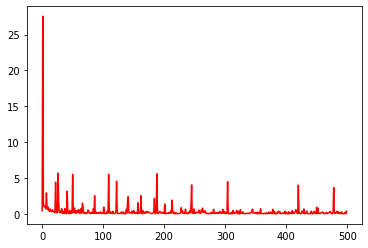

In [12]:
# Graphing losses
plt.plot(np.array([x.detach().numpy() for x in train_losses]), 'r')
plt.plot(np.array([x.detach().numpy() for x in val_losses]), 'b')

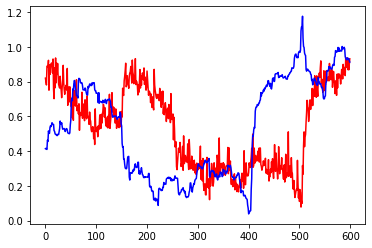

In [13]:
# MODEL PERFORMANCE - TRAINING PART
if not model:
  model=VolForecast(input_size=len(input_fields), seq_len=seq_len, horizon=horizon)
  model.load_state_dict(torch.load('./model'))
  
plot_model_performance_single_horizon(model, train_x, train_y, num_samples=600, horizon=horizon)

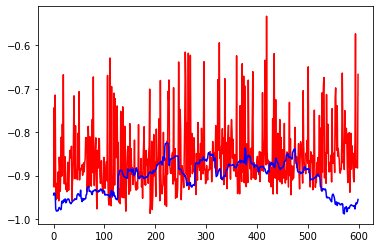

In [14]:
# MODEL'S PERFORMANCE - VALIDATION PART
if not model:
  model=VolForecast(input_size=len(input_fields), seq_len=seq_len, horizon=horizon)
  model.load_state_dict(torch.load('./model'))

plot_model_performance_single_horizon(model, val_x, val_y, num_samples=600, horizon=horizon)